In [1]:
### Largely based on the LLFormer training code but altered to compute Satellite paper metrics 

In [2]:
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from PIL import Image
import os
from skimage import img_as_ubyte
from collections import OrderedDict
from natsort import natsorted
from glob import glob
import numpy as np

from torchvision.transforms import functional as TTF
from utils import ECLLSIE_loss_functions as sat_loss

import cv2
import argparse
from model.LLFormer import LLFormer

In [3]:
import lpips
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt

In [4]:
#inp_dir = './datasets/ExDark/val'
#out_dir = './datasets/ExDark/results/final/results'

PAIRED = True
inp_dir  = './datasets/MIT-Adobe-5K-512/test/low'
high_dir = './datasets/MIT-Adobe-5K-512/test/high'
out_dir  = './datasets/MIT-Adobe-5K-512/results/'

weights = './datasets/ExDark/results/final/model_epoch_19.pth'

In [5]:
# instantiate losses
L_color   = sat_loss.L_color(8)
L_spa     = sat_loss.L_spa()
L_exp     = sat_loss.L_exp(16)
L_tv      = sat_loss.L_TV()

lpips_loss = lpips.LPIPS(net='alex').cuda()

E = 0.575

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/john/.miniconda/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/john/.miniconda/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/john/.miniconda/envs/cv/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [6]:
def save_img(filepath, img):
    cv2.imwrite(filepath, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def load_checkpoint(model, weights):
    checkpoint = torch.load(weights)
    try:
        model.load_state_dict(checkpoint["state_dict"])
    except:
        state_dict = checkpoint["state_dict"]
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:]  # remove `module.`
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)

In [7]:
# pad imput shape so a uniformly shaped average can be collected
def pad_to_shape(img, max_size):
    img = img.squeeze(0)
    h, w = img.shape[1:]
    pad_h = max_size - h
    pad_w = max_size - w
    pad = [(0, 0), (0, pad_h), (0, pad_w)]
    return np.pad(img, pad, mode='constant', constant_values=0)

def radial_profile(psd2d):
    y, x = np.indices(psd2d.shape)
    center = np.array([x.max() / 2.0, y.max() / 2.0])
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int32)

    tbin = np.bincount(r.ravel(), psd2d.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / (nr + 1e-8)
    return radialprofile

def psd(image,max_size):
    """
    Compute 1D PSD for each chanel
    """
    image = pad_to_shape(image.cpu().numpy(), max_size)
    psd_out = np.empty((3,724))
    
    for c in range(3):
        channel = image[c]
        f = fft2(channel)
        fshift = fftshift(f)
        psd2d = (np.abs(fshift) ** 2) / (max_size**2)
        psd1d = radial_profile(psd2d)
        psd1d = 10 * np.log10(psd1d + 1e-12) # convert from powers to dB
        psd_out[c] = psd1d
    return psd_out

In [8]:
# convert to numpy tensor for sklearn
def to_numpy(img_tensor):
    return img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

def to_uint8(img_np):
    return (img_np * 255).clip(0, 255).astype("uint8")

In [9]:
# get the high light version of the image if using paired data
def get_high(file):
    return os.path.join(high_dir,os.path.basename(file))

In [16]:
def lpips(enhanced_img,file):
    
    high_img = Image.open(get_high(file)).convert('RGB')

    high_img = TTF.pil_to_tensor(high_img).float().unsqueeze(dim=0).cuda() / 255.0
    
    lpips_val = lpips_loss(
        # scale to [-1,1]
        2 * enhanced_img - 1,
        2 * high_img - 1
    ).item()

    return lpips_val

In [17]:
os.makedirs(out_dir, exist_ok=True)

files = natsorted(glob(os.path.join(inp_dir, '*.jpg'))
                  + glob(os.path.join(inp_dir, '*.JPG'))
                  + glob(os.path.join(inp_dir, '*.png'))
                  + glob(os.path.join(inp_dir, '*.PNG')))

if len(files) == 0:
    raise Exception(f"No files found at {inp_dir}")

# Load corresponding models architecture and weights

model = LLFormer(inp_channels=3,out_channels=3,dim = 16,
                 num_blocks = [2,4,8,16],num_refinement_blocks = 2,
                 heads = [1,2,4,8],ffn_expansion_factor = 2.66,bias = False,
                 LayerNorm_type = 'WithBias',attention=True,skip = True)
model.cuda()
load_checkpoint(model, weights)
model.eval()

mul = 16
index = 0
psnr_val_rgb = []

# assuming max size of 1024
avg_psd_enhanced = np.zeros([3,724])
avg_psd_ll       = np.zeros([3,724])
avg_lpips = 0
avg_psnr  = 0
avg_ssim  = 0

In [18]:
for file_ in files:
    img = Image.open(file_).convert('RGB')
    
    # ensure minimum size to prevent padding down to zero
    min_size = 64
    max_size = 1024

    if img.size[0] < min_size or img.size[1] < min_size:
        print(f"skipping {file_} — image too small: {img.size}")
        continue
    if img.size[0] > max_size or img.size[1] > max_size:
        print(f"skipping {file_} — image too large: {img.size}")
        continue

    input_ = TF.to_tensor(img).unsqueeze(0).cuda()

    # Pad the input if not_multiple_of 16
    h, w = input_.shape[2], input_.shape[3]
    H, W = ((h + mul) // mul) * mul, ((w + mul) // mul) * mul
    padh = H - h if h % mul != 0 else 0
    padw = W - w if w % mul != 0 else 0
    input_ = F.pad(input_, (0, padw, 0, padh), 'reflect')

    with torch.no_grad():
        enhanced_img = model(input_)

    enhanced_img = torch.clamp(enhanced_img, 0, 1)
    enhanced_img = enhanced_img[:, :, :h, :w]
    enhanced_img = enhanced_img.permute(0, 2, 3, 1).cpu().detach().numpy()
    enhanced_img = img_as_ubyte(enhanced_img[0])

    f = os.path.splitext(os.path.split(file_)[-1])[0]
    save_img((os.path.join(out_dir, f + '.png')), enhanced_img)
    index += 1
    
    # float and channel first
    enhanced_img = torch.tensor(enhanced_img).float().permute(2, 0, 1).unsqueeze(dim=0).cuda() / 255.0
    ll_img = TTF.pil_to_tensor(img).float().unsqueeze(dim=0).cuda() / 255.0

    # LPIPS
    lpips_val = lpips(enhanced_img, file_)
    
    # PSNR
    psnr_val = psnr(to_uint8(to_numpy(ll_img)), to_uint8(to_numpy(enhanced_img)))    

    # SSIM
    ssim_val = ssim(to_uint8(to_numpy(ll_img)), to_uint8(to_numpy(enhanced_img)), channel_axis=2)
    
    # PSE
    avg_psd_enhanced += psd(enhanced_img,max_size)
    avg_psd_ll       += psd(ll_img,max_size)
    
    print(f"LPIPS: {lpips_val}\nPSNR: {psnr_val}\nSSIM: {ssim_val}")
    print('%d/%d' % (index, len(files)))
    avg_lpips += lpips_val
    avg_psnr  += psnr_val
    avg_ssim  += ssim_val

avg_psd_enhanced /= index
avg_psd_ll      /= index
avg_lpips /= index
avg_psnr  /= index
avg_ssim  /= index

print(f"Files saved at {out_dir}")
print('finish !')

LPIPS: 0.42166727781295776
PSNR: 6.055629680522453
SSIM: 0.4082107044632342
1/500
LPIPS: 0.16779565811157227
PSNR: 6.223476973841154
SSIM: 0.42678819921437333
2/500
LPIPS: 0.26002511382102966
PSNR: 6.404297062242138
SSIM: 0.4097117285481291
3/500
LPIPS: 0.22948625683784485
PSNR: 7.48085822441677
SSIM: 0.6732495730860171
4/500
LPIPS: 0.2099740356206894
PSNR: 6.0424501212273
SSIM: 0.36776055738751473
5/500
LPIPS: 0.2937065660953522
PSNR: 6.132045432234482
SSIM: 0.38003473519689673
6/500
LPIPS: 0.25217968225479126
PSNR: 6.670855833485413
SSIM: 0.42057464530801275
7/500
LPIPS: 0.2603992223739624
PSNR: 7.342452676007375
SSIM: 0.41076543732310117
8/500
LPIPS: 0.2849186360836029
PSNR: 6.166188435925468
SSIM: 0.5472033495699034
9/500
LPIPS: 0.36893463134765625
PSNR: 5.897631030266027
SSIM: 0.5923171664967387
10/500
LPIPS: 0.44659239053726196
PSNR: 5.973886609021928
SSIM: 0.6076193367306345
11/500
LPIPS: 0.22845414280891418
PSNR: 6.4104715497454565
SSIM: 0.45816463916283706
12/500
LPIPS: 0.2758

In [ ]:
print(f"LPIPS: {avg_lpips}\nPSNR: {avg_psnr}\nSSIM: {avg_ssim}")

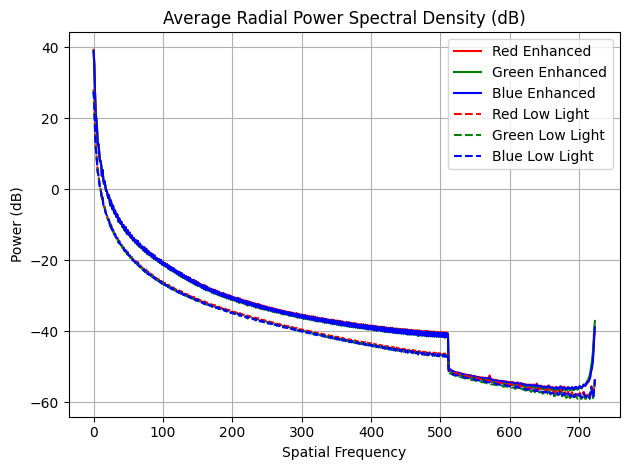

In [23]:
# enhanced image PSDs
plt.plot(avg_psd_enhanced[0], label='Red Enhanced', color='red', linestyle='-')
plt.plot(avg_psd_enhanced[1], label='Green Enhanced', color='green', linestyle='-')
plt.plot(avg_psd_enhanced[2], label='Blue Enhanced', color='blue', linestyle='-')

# original image PSDs
plt.plot(avg_psd_ll[0], label='Red Low Light', color='red', linestyle='--')
plt.plot(avg_psd_ll[1], label='Green Low Light', color='green', linestyle='--')
plt.plot(avg_psd_ll[2], label='Blue Low Light', color='blue', linestyle='--')

plt.xlabel('Spatial Frequency')
plt.ylabel('Power (dB)')
plt.title('Average Radial Power Spectral Density (dB)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

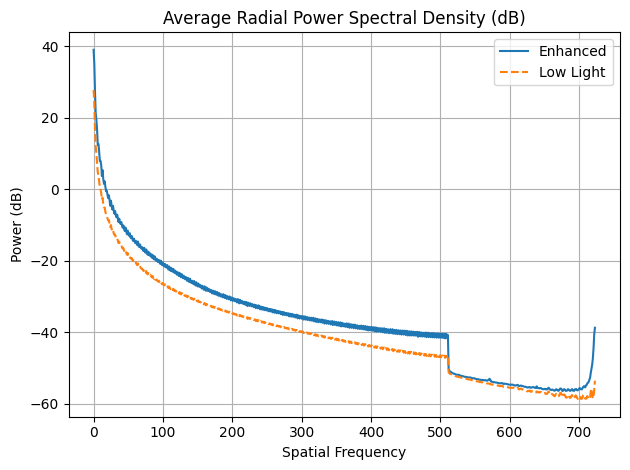

In [24]:
# enhanced image PSDs
plt.plot(np.average(avg_psd_enhanced,axis=0), label='Enhanced', linestyle='-')

# original image PSDs
plt.plot(np.average(avg_psd_ll,axis=0), label='Low Light', linestyle='--')

plt.xlabel('Spatial Frequency')
plt.ylabel('Power (dB)')
plt.title('Average Radial Power Spectral Density (dB)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()